# Projet reconnaissance d'émotion dans un texte

L'objectif de ce projet est d'aboutir à un modèle capable de reconnaître une émotion dans un court texte, en utilisant la base de données IEMOCAP.

Dans un premier temps, on entraîne un réseau de neurone basé sur un article scientifique, puis on exploite des modèles de transformers pré-entraînés.

# Importations des librairies

In [ ]:
import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, RobertaForSequenceClassification, RobertaTokenizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Manipulation des données

Ici on extrait une liste contenant le titre de chaque extrait ainsi que l'émotion associée

In [ ]:
# Fonction permettant de lire le fichier texte et de le transformer en tableau
def txt_to_table(file_path, delimiter='\t'):
    table = []
    with open(file_path, 'r') as file:
        for line in file:
            # Supprime les espaces blancs de début et de fin et divise la ligne en fonction du délimiteur.
            fields = line.strip().split(delimiter)
            table.append(fields)
    return table

def extract_emotions(table):
    tableReduce = []
    extractedList =[]
    lenMax = len(table)
    i= 2
    while i<lenMax:
      tableReduce.append(table[i])
      i = i+1
    for i in range (len(tableReduce)):
      if tableReduce[i] != [""]:
       if tableReduce[i][1].startswith("Ses") and tableReduce[i][2] in ["neu", "ang", "sad","fru","hap","exc"]:
                extractedList.append((tableReduce[i][1], tableReduce[i][2]))
    return extractedList

# Fonction permettant de lire le fichier texte avec un délimiteur d'espace et de le transformer en tableau
def extract_text(file_path):
    table = []
    transformedTable = []
    with open(file_path, 'r') as file:
        for line in file:
            # Diviser la ligne en fonction du délimiteur d'espace
            fields = line.strip().split()
            table.append(fields)
    for row in table :
      transformedRow = [row[0], ' '.join(row[2:])]
      transformedTable.append(transformedRow)
    return transformedTable

def sentence_label(extractedList,extractedText):
  labeledText = []
  for i in range (len(extractedList)):
    j = 0
    while((extractedText[j][0] != extractedList[i][0]) and (j < len(extractedList))):
      j = j+1
    labeledText.append((extractedText[j][1],extractedList[i][1]))
  return labeledText

In [ ]:
# Si cloné
# Traitement général de toutes les données
chemin_emo_part = r"EmoEvaluation/EmoEvaluation"
chemin_transcription_part = r"transcriptions/transcriptions"

data = []
session_folders = ['Session_01', 'Session_02', 'Session_03', 'Session_04', 'Session_05']
for session in session_folders:
  emotions_folder = os.path.join('/IEMOCAP', session,chemin_emo_part)
  listFileEmotions = os.listdir(emotions_folder)
  text_folder = os.path.join('/IEMOCAP', session, chemin_transcription_part)
  listFileText = os.listdir(text_folder)
  for i in range(len(listFileEmotions)):
    filePathEmotions = os.path.join(emotions_folder,listFileEmotions[i])
    if os.path.isfile(filePathEmotions):
      filePathText = os.path.join(text_folder,listFileText[i])
      tableEmotions = txt_to_table(filePathEmotions)
      extractedEmotions = extract_emotions(tableEmotions)
      extractedText = extract_text(filePathText)
      labeledText = sentence_label(extractedEmotions,extractedText)
      data.extend(labeledText)

print(data)
print(len(data))

In [ ]:
# si en local
# Traitement général de toutes les données

chemin_data = r"C:\Users\Fournier\Documents\Cours CS\ST7 numérique au service du facteur humain\IA reconnaissance émotion\IEMOCAP"
chemin_emo_part = r"EmoEvaluation\EmoEvaluation"
chemin_transcription_part = r"transcriptions\transcriptions"

data = []
session_folders = ['Session_01', 'Session_02', 'Session_03', 'Session_04', 'Session_05']
for session in session_folders:
  emotions_folder = os.path.join(chemin_data, session, chemin_emo_part)
  listFileEmotions = os.listdir(emotions_folder)
  text_folder = os.path.join(chemin_data, session, chemin_transcription_part)
  listFileText = os.listdir(text_folder)
  for i in range(len(listFileEmotions)):
    filePathEmotions = os.path.join(emotions_folder,listFileEmotions[i])
    if os.path.isfile(filePathEmotions):
      filePathText = os.path.join(text_folder,listFileText[i])
      tableEmotions = txt_to_table(filePathEmotions)
      extractedEmotions = extract_emotions(tableEmotions)
      extractedText = extract_text(filePathText)
      labeledText = sentence_label(extractedEmotions,extractedText)
      data.extend(labeledText)
print(len(data))

7380


In [ ]:
neu_data = [text for text, emotion in data if emotion == "neu"]
ang_data = [text for text, emotion in data if emotion == "ang"]
hap_data = [text for text, emotion in data if emotion == "hap"]
sad_data = [text for text, emotion in data if emotion == "sad"]
fru_data = [text for text, emotion in data if emotion == "fru"]
exc_data = [text for text, emotion in data if emotion == "exc"]
neu_array = np.array(neu_data)
ang_array = np.array(ang_data)
hap_array = np.array(hap_data)
sad_array = np.array(sad_data)
exc_array = np.array(exc_data)
fru_array = np.array(fru_data)

print(f"nombre de neutre:{len(neu_array)} ; nombre de angry:{len(ang_array)} ; nombre de happy:{len(hap_array)} ; nombre de sad:{len(sad_array)} ; nombre de excited:{len(exc_array)} ; nombre de frustrated:{len(fru_array)}")

nombre de neutre:1708 ; nombre de angry:1103 ; nombre de happy:595 ; nombre de sad:1084 ; nombre de excited:1041 ; nombre de frustrated:1849


# Le batch des données :

Dans cette partie je vais batcher les données, les reunirs en paquets afin que les futurs réseaux s'entrainent dessus correctement et efficacement. Comme vu ci dessus, les classes sont déséquilibrées, il va falloir prendre cela en compte dans notre batch de données pour éviter un oversampling sur les classes les plus représenté lors de l'entrainement.

Je décide donc de faire des batchs de 60 transcriptions, avec 10 de chaque classe (neutral, angry, happy, sad, excited, frustrated)

In [ ]:
class_indices = {
    0: neu_array,
    1: ang_array,
    2: hap_array,
    3: sad_array,
    4: exc_array,
    5: fru_array
}

In [ ]:
# Définir le nbr d'exemple pour 1 émotion dans 1 batch
nbr_emo_par_batch = 10

# Concaténer toutes les valeurs et les labels dans des listes séparées
X = np.concatenate(list(class_indices.values()))
y = np.concatenate([[key] * len(class_indices[key]) for key in class_indices])

# Créer un objet StratifiedShuffleSplit, cela sert pour faire une validation croisé en split pour fine-tuned un model pré-trained, on pourra donc en avoir besoin par la suite
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


# ici on créé quatres listes, deux de train et deux de test de taille 80% desdonnées pour le train et 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)


compteur = [0,0,0,0,0,0]
for i in y_train :
    compteur[i-1] +=1

print(compteur)

nbr_batch_train = min(compteur[i] // nbr_emo_par_batch for i in range(len(compteur)))

print(nbr_batch_train)

In [ ]:
def creer_batch_train_random(X_train,y_train):
    all_batches = []

    all_batches_indices = []

        # Créer des batches équilibrés pour chaque split
    for i in range(nbr_batch_train):
        # Sélectionner des indices équilibrés de chaque classe pour former un batch
        batch_indices = []
        for label in np.unique(y_train):

            indices_du_label = []

            while len(indices_du_label) != nbr_emo_par_batch:

                indice_valeur = np.random.choice(np.where(np.array(y_train) == label)[0])

                if indice_valeur not in indices_du_label:
                    if indice_valeur not in all_batches_indices:
                        indices_du_label.append(indice_valeur)


            batch_indices.extend(indices_du_label)
            all_batches_indices.extend(indices_du_label)

        # Mélanger les indices du batch final
        np.random.shuffle(batch_indices)

            # Créer le batch en combinant X_batch et y_batch
        batch = [(X_train[index], y_train[index]) for index in batch_indices]

        # Ajouter le batch à la liste
        all_batches.append(batch)

    return all_batches

all_batches = creer_batch_train_random(X_train,y_train)

# Vérifier la taille de la liste de batches
print(len(all_batches))  # Devrait afficher le nombre total de batches
print(len(all_batches[0]))  # Devrait afficher la taille du premier batch
print(all_batches[0])

# repartition des label:
compteur_label=[0,0,0,0,0,0]
for donnee,label in all_batches[0]:
    compteur_label[label] +=1
print(compteur_label)  # Devrait afficher la répartition des émotions dans un batch

In [ ]:
def train(model, loss_fn, optimizer, n_epochs=1):

    model.train(True)

    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)

    for epoch_num in range(n_epochs):

        running_corrects = 0.0 # nombre de prédiction juste
        running_loss = 0.0 # loss
        size = 0

        compt_batch = 0

        all_batches = creer_batch_train_random(X_train,y_train)



        num_batches = len(all_batches)
        all_batches_indices = list(range(num_batches))

        np.random.shuffle(all_batches_indices)

        for batch_index in all_batches_indices:

            compt_batch +=1
            print(f'on en est au batch {compt_batch} sur {len(all_batches)}')


        # Obtenir le batch correspondant à l'index mélangé
            batch_data = all_batches[batch_index]

            inputs = []
            labels = []

            for donnee,label in batch_data:
                inputs.append(donnee)
                labels.append(label)

            # print(inputs)
            # print(labels)

            labels = torch.tensor(labels,dtype=torch.long).to(device)

            bs = labels.size(0)

            # réinitialiser les gradients stockés pour les paramètres du réseau neuronal
            model.zero_grad()

            outputs = model(inputs)
            # print(outputs.device)

            # calculer la perte sur le training set
            loss = loss_fn(outputs, labels)

            # la back propagation
            loss.backward()

            # la descente de gradient (selon la methode Adam ici)
            optimizer.step()

            # stocker la loss et calculer le nombre de prédictions correctes
            running_loss += loss
            preds = (outputs >= 0.5).type(torch.float32)
            preds_argmax = torch.argmax(preds, dim=1)
            running_corrects += torch.sum(preds_argmax == labels)

            # compter le nombre d'échantillons
            size += bs

            # print(loss/bs)

        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size

        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc

        print('Epoch {} - Loss: {:.4f} Acc: {:.4f}'.format(epoch_num+1, epoch_loss, epoch_acc))
        torch.cuda.empty_cache()

    print(loss_train,acc_train)

    return loss_train, acc_train

# Le premier modèle :

Ce premier réseau de neurones est basé sur l'article scientifique suivant :
Detection of emotion by text analysis using machine learning ; Kristína Machová, Martina Szabóova , Ján Paralič and
Ján Mičko (1 Department of Cybernetics and Artificial Intelligence, Faculty of Electrical Engineering and Informatics, Technical University of Košice, Košice, Slovakia, 2 Department of Social Sciences, Technical University of Košice, Košice, Slovakia)

Les chercheurs y détaillent une architecture ayant en théorie 91% d'accurancy. Cette dernière est composé d'une couche d'embedding, une couche récurrente (LSTM), une couche de convolution, une récurrente et une couche de convolution avec des couches de dropout intermédiare.

J'ai ici choisit de prendre la couche d'embedding proposé par le modèle BERT de google car les couches d'embedding sont compliquées à entrainer (pour extraire la sémantique, rajouter les tokens etc.).

In [ ]:
class analyser_emo(nn.Module):

    def __init__(self, bert_model_name='bert-base-uncased', embedding_dim=128, p=0.5, max_input_length=50, num_classes=6, device = device):

        super(analyser_emo, self).__init__()

        self.max_length = max_input_length

        #couche d'embeding BERT

        # Charger le modèle BERT pré-entraîné et le tokenizer
        self.bert = BertModel.from_pretrained(bert_model_name).to(device)
        self.tokenizer = BertTokenizer.from_pretrained(bert_model_name)
        # Définir la couche linéaire pour ajuster la dimension de l'embedding
        self.linear_bert = nn.Linear(self.bert.config.hidden_size, embedding_dim).to(device)

        # couche de dropout
        self.dropout = nn.Dropout(p=p).to(device)

        #couche recurrent 1
        self.lstm_1 = nn.LSTM(input_size=embedding_dim, hidden_size=128, dropout=p, batch_first=True).to(device)

        #couche conv 1
        self.convolution_1 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=10, stride=3, padding=5).to(device)

        #activation ReLU
        self.activation_Relu = nn.ReLU().to(device)

        #couche recurrent 2
        self.lstm_2 = nn.LSTM(input_size=128, hidden_size=128, dropout=p, batch_first=True).to(device)

        #couche conv 2
        self.convolution_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=10, stride=3, padding=5).to(device)

        #couche dense final
        self.lin = nn.Linear(in_features=128*1, out_features=num_classes).to(device)

        self.device = device


    def forward(self, input_text):
        inputs = self.tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)

        # Transférez les données d'entrée au bon dispositif
        inputs = {name: tensor.to(self.device) for name, tensor in inputs.items()}
        outputs = self.bert(**inputs)
        # Obtenir l'embedding BERT et le redimensionner
        bert_embedding = outputs.last_hidden_state.mean(dim=1)  # Moyenne des embeddings de chaque token
        bert_embedding = self.linear_bert(bert_embedding)


        dropout_1 = self.dropout(bert_embedding)
        couche_rec_1, _ = self.lstm_1(dropout_1.unsqueeze(1))  # Ajouter une dimension pour la convolution 1D
        couche_rec_1 = couche_rec_1.permute(0, 2, 1)
        couche_conv_1 = self.convolution_1(couche_rec_1)  # Transposer les dimensions pour correspondre aux attentes de la couche de convolution
        couche_act_relu = self.activation_Relu(couche_conv_1.permute(0, 2, 1))  # Transposer les dimensions pour correspondre aux attentes de la LSTM 2
        couche_rec_2, _ = self.lstm_2(couche_act_relu)  # LSTM 2
        couche_conv_2 = self.convolution_2(couche_rec_2.permute(0, 2, 1))  # Transposer les dimensions pour correspondre aux attentes de la couche de convolution
        couche_lin = self.lin(couche_conv_2.squeeze())

        output_final = torch.softmax(couche_lin, dim=-1)

        return output_final.to(self.device)

On test ici notre modèle pour voir si toutes les couches ont été bien reliés au niveau des dimensions.
On peut voir que la sortie (la proba pour chaque classes) est bien repartie (un peu près une proba de 1/6 ~ 0.167).

In [ ]:
# 1er modèle test
analyser_1 = analyser_emo()
print(analyser_1.forward(['salut']))

importation et entrainement du premier modèle :

---

On va ici importer et mettre notre modèle sur cuda pour pouvoir entrainer notre modèle (sur CPU, la RAM crash assez vite).

In [ ]:
analyser_emotion = analyser_emo()

if torch.cuda.is_available():
    # Parcourir les paramètres de votre modèle
    for param in analyser_emotion.parameters():
        # Transférer chaque paramètre sur CUDA
        param.data = param.data.to('cuda')

    # Transférer également votre modèle sur CUDA
    analyser_emotion.to('cuda')
else:
    print("CUDA n'est pas disponible. Les tenseurs resteront sur CPU.")

---

Ici on va "geler" les poids de la couche d'embedding pour améliorer la vitesse de l'entrainement. En effet cette couche étant déjà pré-entraînée, elle sort des tokens déjà utiles pour notre réseau, pas besoin de la ré-entrainer (d'autant que cela demande beaucoup de puissance de calcul et de temps).
Pour geler une couche, on arrête de traquer le gradient.

In [ ]:
# gel des poids de la couche de l'embedding

for name, param in analyser_emotion.named_parameters():
    if 'bert' in name or 'tokenizer' in name or 'linear_bert' in name:
        param.requires_grad = False


---
On commence alors l'entrainement en utilisant la méthode Adam (l'adaptation du gradient en fonction de ses moments d'ordre 1 et 2 actuel et précédent est utile ici) et la cross entropy comme fonction de perte (car on a des classes).

Le learning rate est à modifier arbitrairement mais cependant, le modèle ayant du mal à s'entrainer (comme vous le verrez), j'ai choisi ici un learning rate élevé.
(remarque : un lr de 100 donne une loss qui diverge parfois et est donc trop élevé)

In [ ]:
learning_rate = 10
n_epochs = 5

optimizer = optim.Adam(analyser_emotion.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
torch.cuda.empty_cache()  # Videz le cache CUDA

print(n_epochs, learning_rate)

training_loss , training_acc = train(analyser_emotion,  loss_fn, optimizer, n_epochs)

on en est au batch 1 sur 47
on en est au batch 2 sur 47
on en est au batch 3 sur 47
on en est au batch 4 sur 47
on en est au batch 5 sur 47
on en est au batch 6 sur 47
on en est au batch 7 sur 47
on en est au batch 8 sur 47
on en est au batch 9 sur 47
on en est au batch 10 sur 47
on en est au batch 11 sur 47
on en est au batch 12 sur 47
on en est au batch 13 sur 47
on en est au batch 14 sur 47
on en est au batch 15 sur 47
on en est au batch 16 sur 47
on en est au batch 17 sur 47
on en est au batch 18 sur 47
on en est au batch 19 sur 47
on en est au batch 20 sur 47
on en est au batch 21 sur 47
on en est au batch 22 sur 47
on en est au batch 23 sur 47
on en est au batch 24 sur 47
on en est au batch 25 sur 47
on en est au batch 26 sur 47
on en est au batch 27 sur 47
on en est au batch 28 sur 47
on en est au batch 29 sur 47
on en est au batch 30 sur 47
on en est au batch 31 sur 47
on en est au batch 32 sur 47
on en est au batch 33 sur 47
on en est au batch 34 sur 47
on en est au batch 35 s

Text(0, 0.5, 'CE loss')

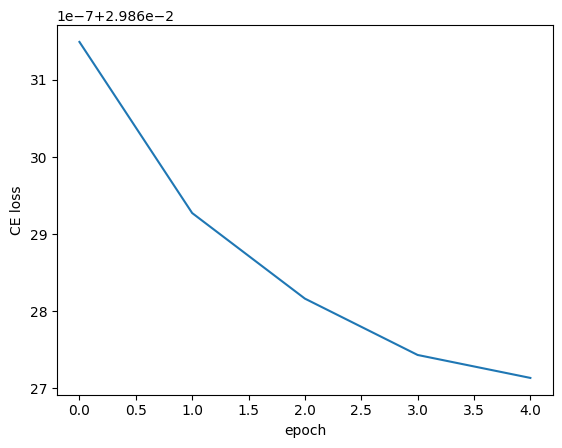

In [ ]:
plt.plot(training_loss)
plt.xlabel('epoch')
plt.ylabel('CE loss')

In [ ]:
plt.plot(training_acc)
plt.xlabel('epoch')
plt.ylabel('acc')


---
En conclusion de ce modèle : il est sans doute efficace selon l'article mais beaucoup trop compliqué à entrainer avec nos ressources. Cela est sans doute dû au LSTM qui possède énormément de paramètres ( ici 4*(128+128+1)*128=131 584 par couche récurrente, donc avec les couches de convolution ça fait beaucoup).

# 2ème modèle (en utilisant le transformer BERT)

BERT :  Bidirectional Encoder Representations from Transformers

Les transformers sont très efficace pour le NLP, c'est pourquoi j'ai choisit un transformers pré-entrainé pour résoudre notre problème. Le transformer BERT, au vu de sa description et des bases de données sur lesquelles il s'est entrainé semblait alors être le plus pertinent (même si le choix est quelque peu arbitraire).

BERT a été pré-entraîné (par Google AI) sur un large corpus de données textuelles provenant de diverses sources, telles que des articles de Wikipédia, des livres, des documents web, des forums en ligne, des articles de presse, etc. L'objectif de ce pré-entraînement était de capturer des représentations linguistiques générales qui peuvent être ensuite adaptées à différentes tâches spécifiques.

J'utiliserai ici la tâche de classification. On peut voir que BERT n'a pas été entrainé sur la base de donnée IEMOCAP car l'accuracy est au départ de 0.167

On définit donc une classe pour notre modèle basé sur BERT :

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes=6, pretrained_model_name='bert-base-uncased', device = device):
        super(BertClassifier, self).__init__()
        self.num_classes = num_classes
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
        self.bert = BertForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_classes).to(device)

        self.device = device


    def forward(self, input_text):
        # Tokenization
        inputs = self.tokenizer(input_text, return_tensors='pt', padding=True, truncation=True).to(self.device)
        # Classification
        outputs = self.bert(**inputs)
        outputs_final = torch.softmax(outputs.logits, dim=-1)

        return outputs_final

---
importation du modèle et entrainement du second model (de la même manière que pour le premier modèle).

In [ ]:
classificateur_emo_bert = BertClassifier()

if torch.cuda.is_available():
    print("on va sur cuda")
    # Parcourir les paramètres de votre modèle
    for param in classificateur_emo_bert.parameters():
        # Transférer chaque paramètre sur CUDA
        param.data = param.data.to('cuda')

    # Transférer également votre modèle sur CUDA
    classificateur_emo_bert.to('cuda')
else:
    print("CUDA n'est pas disponible. Les tenseurs resteront sur CPU.")

---
Ici, le lr est choisit beaucoup plus petit car ce modèle converge beaucoup plus rapidement que le premier. En général, je choisis un lr de 1e-1 pour les 10 premières epochs, puis un 1e-2 pour les 10 suivantes et enfin un 1e-3 pour le reste. Cela permet que le modèle reste précis mais s'entraine rapidement.

In [ ]:
learning_rate = 1e-3
n_epochs = 10

optimizer = optim.Adam(classificateur_emo_bert.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

(j'ai gardé les différentes loss et accuracy lors des entrainements précédents. On peut notamment voir que le modèle arrive à 82% d'accuracy.

In [ ]:
torch.cuda.empty_cache()  # Videz le cache CUDA

print(n_epochs,learning_rate)
training_loss , training_acc = train(classificateur_emo_bert, loss_fn, optimizer, n_epochs)

plt.plot(training_loss)
plt.xlabel('epoch')
plt.ylabel('CE loss')

plt.plot(training_acc)
plt.xlabel('epoch')
plt.ylabel('acc')

# loss =[0.02765068 0.02725666 0.02704823 0.02664275 0.02634453 0.02612578
#  0.02590721 0.0254673  0.02523997 0.02495639 0.02461087 0.02422475
#  0.02403708 0.02364573 0.02349734 0.0232953  0.02313531 0.02286776
#  0.02290078 0.02264368 0.0223601  0.02226738 0.0221536  0.02195324
#  0.02183018 0.02187026 0.02168758 0.02147265 0.02150043 0.02145139]
# acc =[0.35531915 0.39397163 0.40957447 0.43617021 0.4606383  0.46241135
#  0.48262411 0.52092199 0.53758865 0.55957447 0.5893617  0.60460993
#  0.61843972 0.63971631 0.64751773 0.66631206 0.66595745 0.68439716
#  0.68439716 0.69822695 0.71702128 0.71950355 0.72304965 0.7393617
#  0.74007092 0.73723404 0.75248227 0.76879433 0.76347518 0.76312057]
# loss =[0.02145962 0.02129947 0.02131816 0.02125578 0.02118106 0.02104496
#  0.02109007 0.02104837 0.02093198 0.02097597 0.02086502 0.02083805
#  0.02093464 0.02080769 0.02071834 0.0206867  0.02066573 0.02071064
#  0.02064641 0.02066663 0.02059581 0.02064744 0.02055597 0.0205692
#  0.02048292 0.02056026 0.02053437 0.02048611 0.02040847 0.02040384]
#  acc =[0.76205674 0.77021277 0.76843972 0.77411348 0.77836879 0.78865248
#  0.78652482 0.78687943 0.79326241 0.78865248 0.79751773 0.7964539
#  0.7929078  0.80141844 0.80602837 0.80815603 0.80567376 0.80390071
#  0.80992908 0.8070922  0.81028369 0.80886525 0.81347518 0.81028369
#  0.81843972 0.81347518 0.8141844  0.81737589 0.82234043 0.8212766 ]

# deuxième session en recommençant de zéro car le réseau s'est mal enregistré

# loss =[0.01419637 0.01396663 0.013868   0.01357411 0.01312468 0.01280451
#  0.01259687 0.01232456 0.01220601 0.01204682]
#  acc =[0.16666667 0.18903319 0.22727273 0.28102453 0.36075036 0.41594517
#  0.4498557  0.48268398 0.50180375 0.51623377]
# loss =[0.01163287 0.0115118  0.01135006 0.01138314 0.01137112 0.01134926
#  0.01140202 0.01118329 0.01117278 0.01125082]
#  acc =[0.57395382 0.59632035 0.62121212 0.61147186 0.61616162 0.61796537
#  0.60822511 0.64105339 0.64646465 0.62806638]
# loss =[0.01116812 0.0110818  0.01125656 0.01110577 0.01117366 0.01113716
#  0.01114397 0.01113306 0.01099516 0.01112097]
#  acc =[0.64321789 0.65836941 0.63095238 0.65151515 0.64574315 0.65007215
#  0.6453824  0.6468254  0.66594517 0.65367965]
# loss =[0.01110605 0.01103843 0.01098787 0.01103318 0.01111039 0.01099524
#  0.01115685 0.01109176 0.01114987 0.01110056]
#  acc =[0.65151515 0.66017316 0.66991342 0.65873016 0.64862915 0.66738817
#  0.64430014 0.6489899  0.6475469  0.6511544 ]

Conclusion sur ce modèle : ce dernier s'entraine bien plus rapidement que le modèle précédent et nous permet d'avoir des résultats bien plus quantitatif (proche de ceux de la litérrature scientifique).

# 3eme modèle : utilisation de RoBERTa


Ici j'utilise RoBERTa (Robustly optimized BERT approach) qui est également un transformers. RoBERTa est une amélioration de BERT développée par Facebook AI. Il est conçu pour être plus robuste et performant que BERT en appliquant diverses techniques d'optimisation. RoBERTa est entraîné sur une quantité encore plus importante de données textuelles et utilise des stratégies d'entraînement plus avancées pour améliorer ses performances sur une variété de tâches de traitement du langage naturel.

In [ ]:
class RobertaClassifier(nn.Module):
    def __init__(self, num_classes=6, pretrained_model_name='roberta-base', device=device):
        super(RobertaClassifier, self).__init__()
        self.num_classes = num_classes
        self.tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name)
        self.roberta = RobertaForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_classes).to(device)
        self.device = device

    def forward(self, input_text):
        # Tokenization
        inputs = self.tokenizer(input_text, return_tensors='pt', padding=True, truncation=True).to(self.device)
        # Classification
        outputs = self.roberta(**inputs)
        outputs_final = torch.softmax(outputs.logits, dim=-1)

        return outputs_final

---
Importation et entrainement du troisième modèle :

(de même que précédement)

In [ ]:
classificateur_emo_RoBERTa = RobertaClassifier()

if torch.cuda.is_available():
    print("on va sur cuda")
    # Parcourir les paramètres de votre modèle
    for param in classificateur_emo_RoBERTa.parameters():
        # Transférer chaque paramètre sur CUDA
        param.data = param.data.to('cuda')

    # Transférer également votre modèle sur CUDA
    classificateur_emo_RoBERTa.to('cuda')
else:
    print("CUDA n'est pas disponible. Les tenseurs resteront sur CPU.")

(j'applique ici la même méthode de variation du learning rate que pour BERT)

In [ ]:
learning_rate = 1e-2
n_epochs = 10

optimizer = optim.Adam(classificateur_emo_RoBERTa.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

(J'ai également ici conservé les valeurs de la loss et de l'accuracy pour l'entraineemnt de ce modèle et on observe qu'on obtient une accuracy ~ 67%)

In [ ]:
torch.cuda.empty_cache()  # Videz le cache CUDA
print(learning_rate, n_epochs)
training_loss , training_acc = train(classificateur_emo_RoBERTa, loss_fn, optimizer, n_epochs)

plt.plot(training_loss)
plt.xlabel('epoch')
plt.ylabel('CE loss')

plt.plot(training_acc)
plt.xlabel('epoch')
plt.ylabel('acc')


# loss =[0.02987032 0.02985641 0.02983716 0.02940839 0.02915803 0.02891392
#  0.02824112 0.0284073  0.02801978 0.02795586]
#  acc =[0.16666667 0.16666667 0.16666667 0.18085106 0.22588652 0.2606383
#  0.3248227  0.31205674 0.34078014 0.3393617 ]
# loss =[0.02692681 0.02615466 0.02586578 0.0257286  0.02542788 0.02515948
#  0.02547382 0.02507261 0.02493977 0.02456494 0.02456875 0.02448062
#  0.02458525 0.02442469 0.02412935 0.02420645 0.02396414 0.02406923
#  0.02386605 0.02396385]
#  acc =[0.42056738 0.4712766  0.48723404 0.49219858 0.51312057 0.53546099
#  0.51489362 0.5358156  0.5429078  0.56631206 0.56950355 0.5751773
#  0.5677305  0.57801418 0.59609929 0.58900709 0.60531915 0.59539007
#  0.61170213 0.60390071]
# on double la taille du batch :
# loss =[0.01170279 0.01180711 0.01186781 0.0116768  0.01178388 0.01169416
#  0.01167699 0.0116847  0.01166893 0.01164661 0.01165959 0.01160242
#  0.01163244 0.01144577 0.01157438 0.01163777 0.01150932 0.01149496
#  0.01153449 0.01158204]
#  acc =[0.64202899 0.62862319 0.61992754 0.64275362 0.62971014 0.63876812
#  0.64130435 0.64166667 0.64456522 0.64565217 0.64456522 0.65217391
#  0.65       0.66992754 0.65543478 0.64673913 0.66304348 0.66268116
# #  0.65724638 0.65543478]
# loss =[0.01151284 0.01135067 0.011437   0.01143575 0.01153868 0.01159436
#  0.01155198 0.0115619  0.01155206 0.01157762]
#  acc =[0.66123188 0.68224638 0.67028986 0.66992754 0.66086957 0.65326087
#  0.65652174 0.65471014 0.65615942 0.65507246]
# loss =[0.01149768 0.01143562 0.01148595 0.01143775 0.01145755 0.01133253
#  0.01157295 0.01138732 0.01149544 0.01141403]
#  acc =[0.66485507 0.6692029  0.66630435 0.66775362 0.67210145 0.68297101
#  0.65253623 0.67826087 0.6615942  0.67028986]

Conclusion sur ce modèle : nous n'observons pas une réel amélioration par rapport au modèle basé sur BERT.

# Le test :

Ici j'ai fait un test manuel avec une phrase que l'on rentre pour voir réelement le résultat de notre travail.

In [ ]:
#test manuel
#rappel:
    # 0: neutral,
    # 1: angr
    # 2: happy
    # 3: sad
    # 4: excited
    # 5: frustrated

sent = "I can't wait to see you"

model = classificateur_emo_RoBERTa

print(torch.argmax(model.forward([sent])))
print(classificateur_emo_RoBERTa.forward([sent]))

Ici on va batcher les données de test en batch de 64 (pour que ça soit facilement traité par le GPU) et un batch avec ceux qui reste. Ici on ne fait plus attention de mélanger, le deséquilibre des classes dans le batch n'est plus un problème car le modèle ne s'entraine pas dessus.

In [ ]:
# pour batcher les données de test :
print(len(X_test))

X_test_batché = []

for i in range(23):
    batch_test = [X_test[j] for j in range(i*64,(i+1)*64)]
    X_test_batché.append(batch_test)


X_test_batché.append([X_test[1474],X_test[1475]])

print(f"nombre de batch de test {len(X_test_batché)}")

y_test_batché = []

for i in range(23):
    batch_test = [y_test[j] for j in range(i*64,(i+1)*64)]
    y_test_batché.append(batch_test)

y_test_batché.append([y_test[1474],y_test[1475]])


---

Ici fonction de test classique, on fait bien attention à mettre la variable model.train sur False et a ne pas faire de back-prop ou de descente de gradient.


In [ ]:
def test(model,donnee_test,label_test,metric):
    model.train(False)
    loss_tot = 0
    running_corrects = 0.0 # nombre de prédiction correct
    running_loss = 0.0 # loss


    for i in range(len(donnee_test)):

        input = donnee_test[i]
        label = label_test[i]
        model.zero_grad()
        output = model(input)
        label = torch.tensor(label).to(device)


        loss = metric(output,label)

        preds = (output >= 0.5).type(torch.float32)
        preds_argmax = torch.argmax(preds, dim=1)
        running_corrects += torch.sum(preds_argmax == label)

        running_loss += loss

    size = len(X_test)

    loss_tot = running_loss / size
    acc = running_corrects.item() / size


    return loss_tot, acc

---

Ici j'ai également conservé certaines valeurs de loss et d'accuracy pour les modèles. On observe qu'on se situe plus vers 50% pour la phase de test.

In [ ]:

torch.cuda.empty_cache()  # Videz le cache CUDA

model_a_tester = classificateur_emo_RoBERTa

with torch.no_grad():
  loss_test, acc_test = test(model= model_a_tester, donnee_test=X_test_batché, label_test=y_test_batché, metric=loss_fn)

print(loss_test, acc_test)

# pour RoBERTa :

# tensor(0.0247, device='cuda:0') 0.4993224932249323
# tensor(0.0244, device='cuda:0') 0.5169376693766937
# tensor(0.0244, device='cuda:0') 0.5223577235772358
# tensor(0.0244, device='cuda:0') 0.521680216802168
# tensor(0.0244, device='cuda:0') 0.521680216802168

# pour BERT:
# tensor(0.0255, device='cuda:0') 0.45121951219512196 au bout de 10 epochs
# tensor(0.0243, device='cuda:0') 0.5277777777777778 au bout de 20 epochs
# tensor(0.0243, device='cuda:0') 0.5230352303523035 au bout de 30 epochs
# tensor(0.0243, device='cuda:0') 0.5271002710027101 au bout de 40 epochs
